In [4]:
# Import stardard python libraries:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy, mirage, seaborn for plots:
import astropy.units as q
from mirage.soss_simulator import SossSim
import seaborn
seaborn.set_style('ticks')

# Import utils script:
import utils

## 1. Introduction
---------------

Let's first use our `utils` script to generate a stellar spectrum consistent with WASP-43. First, define stellar properties of WASP-43:

In [2]:
teff, logg, feh, jmag = 4520, 4.6, -0.01, 8

Our `utils` script can get the closest ATLAS or PHOENIX spectrum for those properties. Let's use the ATLAS spectrum:

In [3]:
star_wavelength, star_flux = utils.get_stellar_model(teff=teff, logg=logg, feh=feh, jmag=jmag)

Let's plot this:

Text(0.5, 1.0, 'Stellar spectrum of WASP-43')

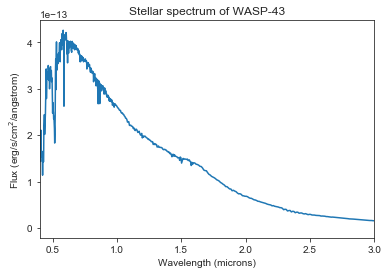

In [7]:
plt.plot(star_wavelength, star_flux)
plt.xlim(0.4,3.)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (erg/s/cm$^2$/angstrom)')
plt.title('Stellar spectrum of WASP-43')

Let's similarly define a flat transit spectrum for WASP-43b:

In [8]:
planet_wavelength, planet_tspectrum = np.copy(star_wavelength), np.ones([len(star_wavelength)])*0.0136059394

## 2. Running `mirage`
---------------

All right, now we can do a test run of `mirage` with SOSS. This doesn't do much right now, however, because:

1. The `yaml` parameter file used below sets a 3-group, 3-integration exposure.
2. The planet properties have not been defined (e.g., orbital parameters, etc.).
3. The time of the start of the exposure has not been chosen such that we should observe a transit based on the planet properties in the previous point (this latest can be done from the parameter file itself).

Let's give it a test run nonetheless --- note I'm using _my_ fork of `mirage` (https://github.com/nespinoza/mirage/tree/add_soss) which fixes some bugs we were seeing:

In [10]:
sim = SossSim(paramfile = 'files/niriss_soss_substrip256_clear.yaml', \
              star=[star_wavelength, star_flux], \
              planet=[planet_wavelength, planet_tspectrum])

And, let's create the exposure! This should take a while (like 45 mins...):

In [ ]:
sim.create()

2021-03-12 17:46:32,289 - mirage.soss_simulator - INFO - 

Running soss_simulator....



2021-03-12 17:46:32,289 - stpipe - INFO - 

Running soss_simulator....



2021-03-12 17:46:32,289 - stpipe - INFO - 

Running soss_simulator....

2021-03-12 17:46:32,292 - mirage.soss_simulator - INFO - Using parameter file: 


2021-03-12 17:46:32,292 - stpipe - INFO - Using parameter file: 


2021-03-12 17:46:32,292 - stpipe - INFO - Using parameter file: 
2021-03-12 17:46:32,294 - mirage.soss_simulator - INFO - files/niriss_soss_substrip256_clear.yaml


2021-03-12 17:46:32,294 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml


2021-03-12 17:46:32,294 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml
Simulating WASP43 in WASP43 transit observation
Configuration: SUBSTRIP256 + CLEAR
Groups: 3, Integrations: 3

Constructing frames for chunk 1/1...
